![UTFSM](https://github.com/tclaudioe/Scientific-Computing-V3/blob/main/images/Departamento%20de%20Inform%C3%A1tica%20cromatica%20negra%404x-8.png?raw=true)
# INF-285 - Computación Científica
## Roots of 1D functions
## Version: 1.45
## [Acknowledgements](#acknowledgements)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tclaudioe/Scientific-Computing-V3/blob/main/03_roots_of_1D_functions.ipynb)

<div id='toc' />

## Table of Contents
* [Introduction](#intro)
* [Bisection Method](#bisection)
* [Fixed Point Iteration and Cobweb diagram](#fpi)
* [FPI - example from textbook](#fpi-textbook-example)
* [Newton Method](#nm)
* [Wilkinson Polynomial](#wilkinson)
* [Acknowledgements](#acknowledgements)
* [Extra Examples](#extraexamples)

In [1]:
##########################
# CoLab requirements
# https://stackoverflow.com/questions/44210656/how-to-check-if-a-module-is-installed-in-python-and-if-not-install-it-within-t
##########################

# https://pypi.org/project/colorama/

import importlib.util
import sys
import subprocess
import os
    
# install_colab_requirements 
libraries = ['numpy', 'scipy', 'matplotlib', 'colorama', 
            'bitstring', 'sympy', 'ipywidgets','pandas']

for library in libraries:
    # Check if the library is already installed
    if importlib.util.find_spec(library) is not None:
        print(f"{library} is already installed.")
    else:
        print(f"{library} is not installed. Installing...")
        # Install the library using pip
        subprocess.check_call([sys.executable, "-m", "pip", "install", library])
        print(f"{library} has been installed.")
# https://stackoverflow.com/questions/53581278/test-if-notebook-is-running-on-google-colab
if os.getenv("COLAB_RELEASE_TAG"):
    print('Installing LaTeX support in CoLab')
    # Adding LaTeX dependencies to CoLab: https://stackoverflow.com/questions/55746749/latex-equations-do-not-render-in-google-colaboratory-when-using-matplotlib
    !sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
else:
   print('Running on local environment')

numpy is already installed.
scipy is already installed.
matplotlib is already installed.
colorama is already installed.
bitstring is already installed.
sympy is already installed.
ipywidgets is already installed.
pandas is already installed.
Running on local environment


In [2]:
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import sympy as sym # type: ignore
%matplotlib inline
from ipywidgets import interact # type: ignore
from ipywidgets import widgets # type: ignore
sym.init_printing()
from scipy import optimize # type: ignore
import pandas as pd # type: ignore
pd.set_option("display.colheader_justify","center")
pd.set_option('display.width', 5)
pd.options.display.float_format = '{:.10f}'.format

from colorama import Fore, Back, Style # type: ignore
# Fore: BLACK, RED, GREEN, YELLOW, BLUE, MAGENTA, CYAN, WHITE, RESET.
# Back: BLACK, RED, GREEN, YELLOW, BLUE, MAGENTA, CYAN, WHITE, RESET.
# Style: DIM, NORMAL, BRIGHT, RESET_ALL
textBold = lambda x: Style.BRIGHT+x+Style.RESET_ALL
textBoldH = lambda x: Style.BRIGHT+Back.YELLOW+x+Style.RESET_ALL

plt.rcParams.update({
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": "Helvetica",
        "font.size": 18,
    })

<div id='intro' />

# Introduction
[Back to TOC](#toc)

In this document we're going to study how to find roots of 1D equations using numerical methods. 
First, let's start with the definition of a root:

<b>Definition</b>: The function $f(x)$ has a <b>root</b> in $x = r$ if $f(r) = 0$.

Example: Let's say we want to solve the equation $r + \log(r) = 3$.
We can re-arrange the equation as follows: $r + \log(r) - 3 = 0$. 
Thus, solving the previous equation is equivalent to find the root of $f(x) = x + \log(x) - 3$.
This example shows how we can translate an equation into a root-finding problem!
We will study now several numerical methods to find roots.

We will start by defining a function $f(x)$ using a __lambda__ definition.

In [3]:
f = lambda x: x+np.log(x)-3

Notice that we have used the NumPy implementation for the logarithmic function. _**Quick question**: what is the base for this implementation? Is it the natural logarithm or logarithm base 10?_

But before we start working on a numerical implementation, we should always consider in solving the problem algebraically.
This can be done with SymPy, i.e. using symbolic computation.
For instance, we will start by defining a symbolic variable:

In [4]:
# Definition of symbolic variable
x = sym.Symbol('x')
# Defining 'symbolic' function
fsym = lambda x: x+sym.log(x)-3
# Finding the root 'symbolically' and obtaining the only root
r=sym.solve(sym.Eq(fsym(x), 0), x)[0]
print(textBoldH('Root obtained:'),r)
print(textBoldH('Numerical root:'),r.evalf())

Root obtained: LambertW(exp(3))
Numerical root: 2.20794003156932


**Lamber W function**: https://en.wikipedia.org/wiki/Lambert_W_function

We will now obtain the root 'manually'.
This is not a recommended path but it is useful initially.

In [5]:
def find_root_manually(r=2.0):
    # Defining a vector to evaluate f(x) in a vectorized fashion
    x = np.linspace(1.5,2.5,1000)
    # reating the figure
    plt.figure(figsize=(5,5))
    # Plotting the function in a vectorized way
    plt.plot(x,f(x),'b-')
    # Plotting the x-axis. 
    # Quick question: Why do we have to multiply 'x' by '0'? What would happen if we only put '0' instead of 'x*0'?
    plt.plot(x,x*0,'r--')
    # Adding the background grid to the plot. We strongly recommend it!
    plt.grid(True)
    # Just adding labels.
    plt.ylabel(r'$f(x)$',fontsize=16)
    plt.xlabel(r'$x$',fontsize=16)
    plt.title(r'$r='+str(r)+', f(r)='+str(f(r))+'$',fontsize=16)
    plt.plot(r,f(r),'k.',markersize=20)
    plt.show()
interact(find_root_manually,r=(1,3,1e-3))

interactive(children=(FloatSlider(value=2.0, description='r', max=3.0, min=1.0, step=0.001), Output()), _dom_c…

<function __main__.find_root_manually(r=2.0)>

<div id='bisection' />

# Bisection Method
[Back to TOC](#toc)

**Bolzano's theorem** [_Page 85, Mathematical Analysis, Thomas Apostol, Second Edition. Addison Wesley_]
Let $f$ be a real-valued and continuous on a compact interval $[a,b]\in\mathbb{R}$, and suppose that $f(a)$ and $f(b)$ hace opposite signs; that is, assume $f(a)\,f(b)<0$. Then there is at least one point $c$ in the open interval $]a,b[$ such that $f(c)=0$.

The bisection method finds the root of a function $f$. 
It requires that:
1. $f$ be a **continuous** function.
2. The interval $[a,b]$, such that $f(a)\cdot f(b) < 0$.

If these 2 conditions are satisfied, it means that there is a value $r$, between $a$ and $b$, for which $f(r) = 0$.
To summarize how this method works, start with the aforementioned interval (checking that there's a root in it), and split it into two smaller intervals $[a,c]$ and $[c,b]$. 
Then, check which of the two intervals contains a root. 
Keep splitting each "eligible" interval until the algorithm converges or the tolerance is achived.

In [6]:
def bisect(f, a, b, tol=1e-5, maxNumberIterations=100, usePandas=True):
    # Evaluating the extreme points of the interval provided
    fa = f(a)
    fb = f(b)
    # Iteration counter.
    i = 0
    # Just checking if the sign is not negative => not root  necessarily 
    if np.sign(f(a)*f(b)) >= 0:
        print('f(a)f(b)<0 not satisfied!')
        return None
  
    # Output table to store the numerical evolution of the algorithm
    output_table = []
    if not usePandas:
        #Printing the evolution of the computation of the root
        print(' i |     a     |     c     |     b     |     fa    |     fc     |     fb     |   b-a')
        print('----------------------------------------------------------------------------------------')
    
    # Main loop: it will iterate until it satisfies one of the two criterias:
    # The tolerance 'tol' is achived or the max number of iterations is reached.
    while ((b-a)/2 > tol) and i<=maxNumberIterations:
        # Obtaining the midpoint of the interval. Quick question: What could happen if a different point is used?
        c = (a+b)/2.
        # Evaluating the mid point
        fc = f(c)
        # Saving the output data
        output_table.append([i, a, c, b, fa, fc, fb, b-a])
        if not usePandas:
            print('%2d | %.7f | %.7f | %.7f | %.7f | %.7f | %.7f | %.7f' % (i+1, a, c, b, fa, fc, fb, b-a))

        # Did we find the root?
        if fc == 0:
            print('f(c)==0')
            break
        elif np.sign(fa*fc) < 0:
            # This first case consider that the new inetrval is defined by [a,c]
            b = c
            fb = fc
        else:
            # This second case consider that the new interval is defined by [c,b]
            a = c
            fa = fc
        # Increasing the iteration counter
        i += 1
    
    if usePandas:
        # Showing final output table
        columns    = ['$i$', '$a_i$', '$c_i$', '$b_i$', '$f(a_i)$', '$f(c_i)$', '$f(b_i)$', '$b_i-a_i$']
        df = pd.DataFrame(data=output_table, columns=columns)
        display(df)
    
    # Computing the best approximation obtaind for the root, which is the midpoint of the final interval.
    xc = (a+b)/2.
    return xc

In [7]:
# Initial example
f1 = lambda x: x+np.log(x)-3
# A different function, notice that x is multiplied to the exponential now and not added, as before.
f2 = lambda x: x*np.exp(x)-3
# This is the introductory example about Fixed Point Iteration
f3 = lambda x: np.cos(x)-x
f4 = lambda x: np.power(x,3.)+4*np.power(x,2.)-2
f5 = lambda x: x-np.cos(x)
f6 = lambda x: x*x-2.
bisect(f6,0,2,tol=1e-12) # Recall to change the 'tol'!

,$i$,$a_i$,$c_i$,$b_i$,$f(a_i)$,$f(c_i)$,$f(b_i)$,$b_i-a_i$
0,0,0.0000000000,1.0000000000,2.0000000000,-2.0000000000,-1.0000000000,2.0000000000,2.0000000000
1,1,1.0000000000,1.5000000000,2.0000000000,-1.0000000000,0.2500000000,2.0000000000,1.0000000000
2,2,1.0000000000,1.2500000000,1.5000000000,-1.0000000000,-0.4375000000,0.2500000000,0.5000000000
3,3,1.2500000000,1.3750000000,1.5000000000,-0.4375000000,-0.1093750000,0.2500000000,0.2500000000
4,4,1.3750000000,1.4375000000,1.5000000000,-0.1093750000,0.0664062500,0.2500000000,0.1250000000
5,5,1.3750000000,1.4062500000,1.4375000000,-0.1093750000,-0.0224609375,0.0664062500,0.0625000000
6,6,1.4062500000,1.4218750000,1.4375000000,-0.0224609375,0.0217285156,0.0664062500,0.0312500000
7,7,1.4062500000,1.4140625000,1.4218750000,-0.0224609375,-0.0004272461,0.0217285156,0.0156250000
8,8,1.4140625000,1.4179687500,1.4218750000,-0.0004272461,0.0106353760,0.0217285156,0.0078125000
9,9,1.4140625000,1.4160156250,1.4179687500,-0.0004272461,0.0051002502,0.0106353760,0.0039062500


It's very important to define a concept called **convergence rate**. 
This rate shows how fast the convergence of a method is at a specified point.

The convergence rate for the bisection is always 0.5 because this method uses the half of the interval for each iteration.

In this particular case we observe $e_{i+1} \approx \dfrac{e_{i}}{2}$, why? where?

<div id='fpi' />

# Fixed Point Iteration and Cobweb diagram
[Back to TOC](#toc)

To learn about the Fixed-Point Iteration we will first learn about the concept of a Fixed Point.

A Fixed Point of a function $g$ is a real number $r$, where $g(r) = r$

The Fixed-Point Iteration is based in the Fixed Point concept and works like this to find the root of a function:

\begin{align*} 
    x_{0} &= initial\_guess \\ 
    x_{i+1} &= g(x_{i})
\end{align*}

To find an equation's root using this method, we'll have to rearrange the equation to make it of the following form $x = g(x)$.
For example, if we want to obtain the root of $f(r)=0$, one could add a zero convenient this way, $f(r)+r=r$, i.e. we add it $r$ on both sides.
This way we have $g(r)=r+f(r)$ and the fixed point iteration could be performed.
In the following example, we'll find the root of $f(x) = x - \cos(x)$ by iterating over the funcion $g(x) = \cos(x)$.

In [8]:
# Just plotting the Cobweb diagram: https://en.wikipedia.org/wiki/Cobweb_plot
def cobweb(x,g=None):
    min_x = np.amin(x)
    max_x = np.amax(x)
    
    plt.figure(figsize=(5,5))
    ax = plt.axes()
    plt.plot(np.array([min_x,max_x]),np.array([min_x,max_x]),'b-')
    for i in np.arange(x.size-1):
        delta_x = x[i+1]-x[i]
        head_length =  np.abs(delta_x)*0.04
        arrow_length = delta_x-np.sign(delta_x)*head_length
        ax.arrow(x[i], x[i], 0, arrow_length, head_width=1.5*head_length, head_length=head_length, fc='k', ec='k')
        ax.arrow(x[i], x[i+1], arrow_length, 0, head_width=1.5*head_length, head_length=head_length, fc='k', ec='k')
    
    if g!=None:
        y = np.linspace(min_x,max_x,1000)
        plt.plot(y,g(y),'r')
    
    plt.title(r'$\mathrm{Cobweb\,diagram}$')
    plt.grid(True)
    plt.show()

# This code performs the fixed point iteration.
def fpi(g, x0, k, flag_cobweb=False):
    # This is where we store all the approximation, 
    # this is technically not needed but we store them because we need them for the cobweb diagram at the end.
    x = np.empty(k+1)
    # Just starting the fixed point iteration from the 'initial guess'
    x[0] = x0
    # Initializing the error in NaN
    error_i = np.nan
    
    # Output table to store the numerical evolution of the algorithm
    output_table = []
    
    # Main loop
    for i in range(k):
        # Iteration
        x[i+1] = g(x[i])
        # Storing error from previous iteration
        error_iminus1 = error_i
        # Computing error for current iteration.
        # Notice that from the theory we need to compute e_i=|x_i-r|, i.e. we need the root 'r'
        # but we don't have it, so we approximate it by 'x_{i+1}'.
        error_i = abs(x[i]-x[i+1])
        output_table.append([i,x[i],x[i+1],error_i,error_i/error_iminus1,error_i/(error_iminus1**((1+np.sqrt(5))/2.)),error_i/(error_iminus1**2)])
    
    # Showing final output table
    columns    = ['$i$', '$x_i$', '$x_{i+1}$', '$e_i$', r'$\frac{e_i}{e_{i-1}}$', r'$\frac{e_i}{e_{i-1}^\alpha}$', r'$\frac{e_i}{e_{i-1}^2}$']
    df = pd.DataFrame(data=output_table, columns=columns)
    display(df)
    
    # Just showing cobweb if required
    if flag_cobweb:
        cobweb(x,g)
    return x[-1]

In [9]:
# First example
g = lambda x: np.cos(x)
# Examples from classnotes
g1 = lambda x: -(3/2)*x+5/2
g2 = lambda x: -(1/2)*x+3/2
g3 = lambda x: -x+2
g4 = lambda x: x/2.+1./x
g4_p = lambda x: 2./x

g = lambda x: np.cos(x)
r=fpi(g, 1.1, 100, False)
print(r)
print('S=|g\'(r)|=',np.abs(-np.sin(r)))

# Suggestions:
# 1.- A very useful and simple 'limit cicle' example! Try it. Credit: anonymous student from class 20210922.
# fpi(lambda x: -x, 2, 10, True)
# 2.- Try the next example. Why do we see 1.0000 for e_{i+1}/e_i over 90 iterations?
# fpi(g, 1, 100, True)
# 3.- The following fixed-point iteration obtain sqrt(2). Credits: Anonymous student from class 20210921 and 20210922.
# gD = lambda x: (x+2)/(x+1)
# fpi(gD, 1, 10, True)

/var/folders/y8/1731kwr16zn8yvy62d113bj40000gp/T/ipykernel_1737/1576229413.py:47: RuntimeWarning: invalid value encountered in scalar divide
  output_table.append([i,x[i],x[i+1],error_i,error_i/error_iminus1,error_i/(error_iminus1**((1+np.sqrt(5))/2.)),error_i/(error_iminus1**2)])


,$i$,$x_i$,$x_{i+1}$,$e_i$,$\frac{e_i}{e_{i-1}}$,$\frac{e_i}{e_{i-1}^\alpha}$,$\frac{e_i}{e_{i-1}^2}$
0,0,1.1000000000,0.4535961214,0.6464038786,NaN,NaN,NaN
1,1,0.4535961214,0.8988770945,0.4452809731,0.6888587582,0.9020802651,1.0656785657
2,2,0.8988770945,0.6224891783,0.2763879163,0.6207045281,1.0233895046,1.3939614885
3,3,0.6224891783,0.8124296367,0.1899404584,0.6872241774,1.5214533412,2.4864479849
4,4,0.8124296367,0.6877366449,0.1246929918,0.6564846311,1.8325822613,3.4562653823
...,...,...,...,...,...,...,...
95,95,0.7390851332,0.7390851332,0.0000000000,NaN,NaN,NaN
96,96,0.7390851332,0.7390851332,0.0000000000,NaN,NaN,NaN
97,97,0.7390851332,0.7390851332,0.0000000000,NaN,NaN,NaN
98,98,0.7390851332,0.7390851332,0.0000000000,NaN,NaN,NaN


0.7390851332151607
S=|g'(r)|= 0.6736120291832148


,$i$,$x_i$,$x_{i+1}$,$e_i$,$\frac{e_i}{e_{i-1}}$,$\frac{e_i}{e_{i-1}^\alpha}$,$\frac{e_i}{e_{i-1}^2}$
0,0,-1.0000000000,0.5403023059,1.5403023059,NaN,NaN,NaN
1,1,0.5403023059,0.8575532158,0.3172509100,0.2059666526,0.1577066649,0.1337183304
2,2,0.8575532158,0.6542897905,0.2032634253,0.6407024187,1.3025857792,2.0195447783
3,3,0.6542897905,0.7934803587,0.1391905682,0.6847792120,1.8331308903,3.3689248858
4,4,0.7934803587,0.7013687736,0.0921115851,0.6617659967,2.2386319334,4.7543882104
5,5,0.7013687736,0.7639596829,0.0625909093,0.6795118030,2.9667844645,7.3770503686
6,6,0.7639596829,0.7221024250,0.0418572579,0.6687434063,3.7072891396,10.6843535909
7,7,0.7221024250,0.7504177618,0.0283153367,0.6764737629,4.8088747218,16.1614448060
8,8,0.7504177618,0.7314040424,0.0190137193,0.6714989660,6.0778297762,23.7150266744
9,9,0.7314040424,0.7442373549,0.0128333125,0.6749501372,7.8138798219,35.4980593268


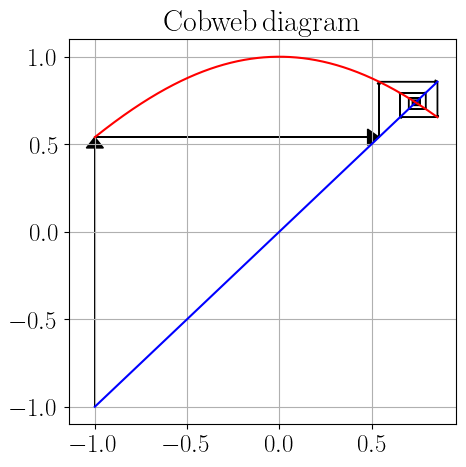

0.7391843997714936
S=|g'(r)|= 0.6736853923002698


In [10]:
g = lambda x: np.cos(x)
r=fpi(g, -1, 20, True)
print(r)
print('S=|g\'(r)|=',np.abs(-np.sin(r)))

/var/folders/y8/1731kwr16zn8yvy62d113bj40000gp/T/ipykernel_1737/1576229413.py:47: RuntimeWarning: invalid value encountered in scalar divide
  output_table.append([i,x[i],x[i+1],error_i,error_i/error_iminus1,error_i/(error_iminus1**((1+np.sqrt(5))/2.)),error_i/(error_iminus1**2)])


,$i$,$x_i$,$x_{i+1}$,$e_i$,$\frac{e_i}{e_{i-1}}$,$\frac{e_i}{e_{i-1}^\alpha}$,$\frac{e_i}{e_{i-1}^2}$
0,0,0.7000000000,0.7394364978,0.0394364978,NaN,NaN,NaN
1,1,0.7394364978,0.7390851605,0.0003513374,0.0089089397,0.0657065358,0.2259059558
2,2,0.7390851605,0.7390851332,0.0000000272,0.0000775606,0.0105803746,0.2207582446
3,3,0.7390851332,0.7390851332,0.0000000000,0.0000000041,0.0001928616,0.1495129869
4,4,0.7390851332,0.7390851332,0.0000000000,0.0000000000,0.0000000000,0.0000000000
5,5,0.7390851332,0.7390851332,0.0000000000,NaN,NaN,NaN
6,6,0.7390851332,0.7390851332,0.0000000000,NaN,NaN,NaN
7,7,0.7390851332,0.7390851332,0.0000000000,NaN,NaN,NaN
8,8,0.7390851332,0.7390851332,0.0000000000,NaN,NaN,NaN
9,9,0.7390851332,0.7390851332,0.0000000000,NaN,NaN,NaN


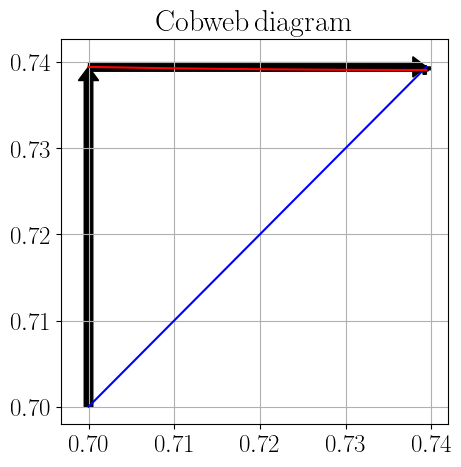

In [11]:
m = 1
f = lambda x: np.power(x-np.cos(x),m)
fp = lambda x: m*np.power(x-np.cos(x),m-1)*(1+np.sin(x))
gN = lambda x: x-m*f(x)/fp(x)
r=fpi(gN, 0.7, 20, True)

Let's quickly explain the Cobweb Diagram we have here. The <font color="blue">blue</font> line is the function $y=x$ and the <font color="red">red</font> is the function $y=g(x)$. 
The point in which they meet is $r=g(r)$, i.e. the fixed point. 
In this particular example, we start at $\color{blue}{y = x = 1.5}$ (the top right corner) and then we "jump" **vertically** to $\color{red}{y = \cos(1.5) \approx 0.07}$. 
After this, we jump **horizontally** to $\color{blue}{x = \cos(1.5) \approx 0.07}$. 
Then, we jump again **vertically** to $\color{red}{y = \cos\left(\cos(1.5)\right) \approx 0.997}$ and so on. 
See the pattern here? We're just iterating over $x = \cos(x)$, getting closer to the center of the diagram where the fixed point resides, in $x \approx 0.739$.

It's very important to mention that the algorithm will converge only if the rate of convergence $S < 1$, where $S = \left| g'(r) \right|$. 
If you want to use this method, you'll have to construct $g(x)$ starting from $f(x)$ accordingly. 
In this example, $g(x) = \cos(x) \Rightarrow g'(x) = -\sin(x)$ and $|-\sin(0.739)| \approx 0.67$.
**Quick question:** Do you see the value 0.67 in the previous table?

### Another example. Look at this web page to undertand the context: https://divisbyzero.com/2008/12/18/sharkovskys-theorem/

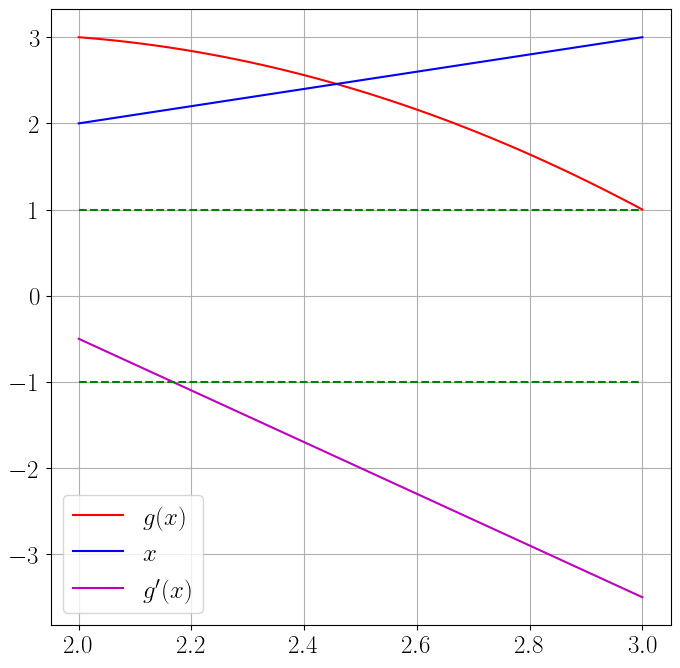

In [12]:
# Consider this funtion
g = lambda x: -(3/2)*x**2+(11/2)*x-2
# Here we compute the derivative of it.
gp = lambda x: -3*x+11/2

# We plot now the funcion itself (red), its derivative (magenta) and the function y=x (blue).
# We also plot the values -1 and 1 with green dashed curves.
# This analyis shows that the fixed point, which is the intersection between the red and blue curves, 
# does not generate a convergent fix-point-iteration since the derivative (magenta curve) has a value
# lower than -1 about the fixed point.
x=np.linspace(2,3,100)
plt.figure(figsize=(8,8))
plt.plot(x,g(x),'r-',label=r'$g(x)$')
plt.plot(x,x,'b-',label=r'$x$')
plt.plot(x,gp(x),'m-',label=r"$g'(x)$")
plt.plot(x,gp(x)*0+1,'g--')
plt.plot(x,gp(x)*0-1,'g--')
plt.grid(True)
plt.legend(loc='best')
plt.show()

What it is interesting about the previous example is that it generates an interesting limit cicle! In the next cell we evaluate the fixed point with initial guess equal to 1. The iteration oscilates generating the following sequence: 1, 2, 3, 1, 2, 3, .... Which is nice!

,$i$,$x_i$,$x_{i+1}$,$e_i$,$\frac{e_i}{e_{i-1}}$,$\frac{e_i}{e_{i-1}^\alpha}$,$\frac{e_i}{e_{i-1}^2}$
0,0,2.5000000000,2.3750000000,0.1250000000,NaN,NaN,NaN
1,1,2.3750000000,2.6015625000,0.2265625000,1.8125000000,6.5526703797,14.5000000000
2,2,2.6015625000,2.1564025879,0.4451599121,1.9648437500,4.9186252467,8.6724137931
3,3,2.1564025879,2.8851060518,0.7287034639,1.6369476318,2.6993786884,3.6772125865
4,4,2.8851060518,1.3823278897,1.5027781621,2.0622629595,2.5077965339,2.8300441286
5,5,1.3823278897,2.7365578014,1.3542299117,0.9011509122,0.7006005618,0.5996566459
6,6,2.7365578014,1.8179450072,0.9186127942,0.6783285366,0.5624056917,0.5008961408
7,7,1.8179450072,3.0413114658,1.2233664586,1.3317542128,1.4034904236,1.4497448994
8,8,3.0413114658,0.8528499139,2.1884615519,1.7888847095,1.5793173857,1.4622639823
9,9,0.8528499139,1.5996450630,0.7467951491,0.3412420696,0.2103028475,0.1559278340


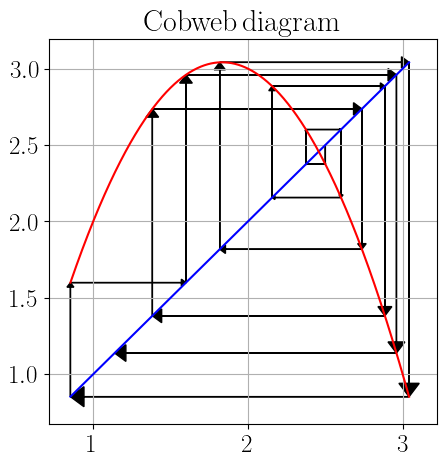

In [13]:
fpi(g, 2.5, 12, True)

# Suggestion, try the following alternative.
#fpi(g, 2.5, 100, True)

However, we prefer **convergent** fixed-point-iterations! Here is interesting way to make a non-convergent FPI into a convergent one.

,$i$,$x_i$,$x_{i+1}$,$e_i$,$\frac{e_i}{e_{i-1}}$,$\frac{e_i}{e_{i-1}^\alpha}$,$\frac{e_i}{e_{i-1}^2}$
0,0,1.0000000000,1.3703703704,0.3703703704,NaN,NaN,NaN
1,1,1.3703703704,1.8702941625,0.4999237921,1.3497942387,2.4938196227,3.6444444444
2,2,1.8702941625,2.3033768846,0.4330827222,0.8662974818,1.3297032607,1.7328590786
3,3,2.3033768846,2.4540725779,0.1506956933,0.3479605294,0.5836352916,0.8034504993
4,4,2.4540725779,2.4576349017,0.0035623237,0.0236391875,0.0761367195,0.1568670408
5,5,2.4576349017,2.4574138249,0.0002210768,0.0620597109,2.0226546124,17.4211316367
6,6,2.4574138249,2.4574279552,0.0000141303,0.0639159592,11.6092963789,289.1120393896
7,7,2.4574279552,2.4574270537,0.0000009015,0.0638009889,63.4158824640,4515.1789387494
8,8,2.4574270537,2.4574271112,0.0000000575,0.0638083384,347.4604260241,70777.8849634007
9,9,2.4574271112,2.4574271075,0.0000000037,0.0638078755,1903.3934160201,1109218.2194221437


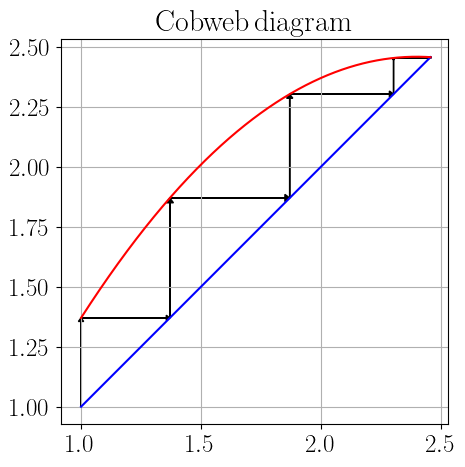

In [14]:
# This is a "palta" hidden in the code! Think about it. Quick question: what is it doing?
a=-1/(1-(-1.7)) # a = -1 / (1 - g'(r)), where does "a" come from?
G = lambda x: x+a*(x-g(x))
fpi(G, 1, 14, True)

<div id='fpi-textbook-example' />

# FPI - example from textbook
[Back to TOC](#toc)


This example is from the textbook. We are trying to find a root of $f(x)=x^3+x-1$.

,$i$,$x_i$,$x_{i+1}$,$e_i$,$\frac{e_i}{e_{i-1}}$,$\frac{e_i}{e_{i-1}^\alpha}$,$\frac{e_i}{e_{i-1}^2}$
0,0,0.7500000000,0.6860465116,0.0639534884,NaN,NaN,NaN
1,1,0.6860465116,0.6823395826,0.0037069290,0.0579628903,0.3170783001,0.9063288301
2,2,0.6823395826,0.6823278039,0.0000117787,0.0031774687,0.1010445936,0.8571700804
3,3,0.6823278039,0.6823278038,0.0000000001,0.0000100600,0.0111899779,0.8540891497
4,4,0.6823278038,0.6823278038,0.0000000000,0.0000009369,1.2779393373,7907.1801642964
5,5,0.6823278038,0.6823278038,0.0000000000,1.0000000000,7252349991.0380630493,9007199254740992.0000000000
6,6,0.6823278038,0.6823278038,0.0000000000,1.0000000000,7252349991.0380630493,9007199254740992.0000000000
7,7,0.6823278038,0.6823278038,0.0000000000,1.0000000000,7252349991.0380630493,9007199254740992.0000000000
8,8,0.6823278038,0.6823278038,0.0000000000,1.0000000000,7252349991.0380630493,9007199254740992.0000000000
9,9,0.6823278038,0.6823278038,0.0000000000,1.0000000000,7252349991.0380630493,9007199254740992.0000000000


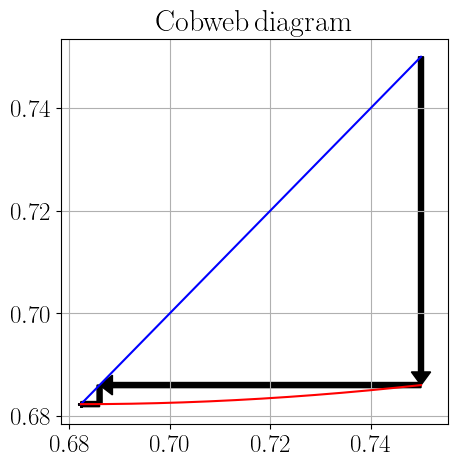

In [15]:
# These are the three functions proposed.
g1 = lambda x: 1-x**3
g2 = lambda x: (1-x)**(1/3)
g3 = lambda x: (1+2*x**3)/(1+3*x**2)
gNew = lambda x: 1/(x**2+1) # by Daniel Roco
# Change the input function to evaluate different functions.
# Are the three functions convergent fixed point iterations?
r=fpi(g3, 0.75, 20, True)
# print(r**3+r-1)

,$i$,$x_i$,$x_{i+1}$,$e_i$,$\frac{e_i}{e_{i-1}}$,$\frac{e_i}{e_{i-1}^\alpha}$,$\frac{e_i}{e_{i-1}^2}$
0,0,0.7500000000,0.6779763150,0.0720236850,NaN,NaN,NaN
1,1,0.6779763150,0.6824480491,0.0044717341,0.0620869943,0.3155874394,0.8620357907
2,2,0.6824480491,0.6823242405,0.0001238086,0.0276869349,0.7840803764,6.1915431709
3,3,0.6823242405,0.6823279092,0.0000036687,0.0296324135,7.7015794735,239.3404885671
4,4,0.6823279092,0.6823278007,0.0000001085,0.0295782485,67.6527024397,8062.2187013180
5,5,0.6823278007,0.6823278039,0.0000000032,0.0295798537,596.0733596783,272587.3459096886
6,6,0.6823278039,0.6823278038,0.0000000001,0.0295798272,5251.4078703182,9215295.8032791298
7,7,0.6823278038,0.6823278038,0.0000000000,0.0295799384,46265.1582823125,311541051.4653884768
8,8,0.6823278038,0.6823278038,0.0000000000,0.0295687236,407441.2748238575,10528180608.3659896851
9,9,0.6823278038,0.6823278038,0.0000000000,0.0294117647,3571338.1223976067,354167948047.3809204102


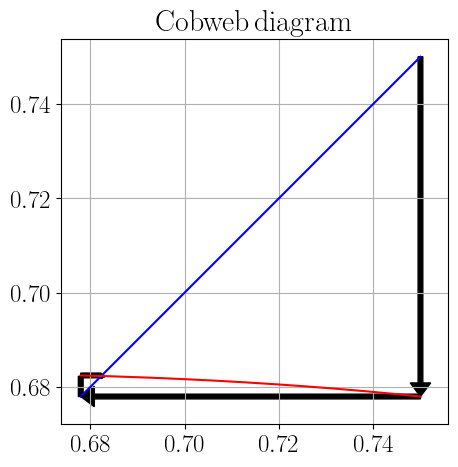

In [16]:
# This is a "hack" to improve the convergence of g2!
a  = -0.6
g4 = lambda x: x+a*(x-g2(x))
fpi(g4, 0.75, 10, True)
# Why does this hack works?

Now that we have found the root, let's compute the derivative of each $g(x)$ used previously and understand what exactly was going on.

In [17]:
g1p = lambda x: -3*x**2
g2p = lambda x: -(1/3)*(1-x)**(-2/3)
g3p = lambda x: ((1+3*x**2)*(6*x**2)-(1+2*x**3)*6*x)/((1+3*x**2)**2)
g4p = lambda x: 1+a*(1-g2p(x))
r=0.6823278038280194
print('What is the conclusion then?')
print([g1p(r), g2p(r), g3p(r), g4p(r)])

What is the conclusion then?
[-1.3967136956303043, -0.7159663452349291, 0.0, -0.029579807140957426]


In [18]:
# Or it may be better to apply the absolute value.
print(np.abs([g1p(r), g2p(r), g3p(r), g4p(r)]))

[1.3967137  0.71596635 0.         0.02957981]


<div id='nm' />

# Newton's Method
[Back to TOC](#toc)

The Newton's method also finds a root of a function $f(x)$ but it requires its derivative, i.e. $f'(x)$.
The algorithm is as follows:
\begin{align*}
    x_0 &= \text{initial guess},\\
    x_{i+1} &= x_i - \dfrac{f(x_i)}{f'(x_i)}.
\end{align*}
For roots with multiplicity equal to 1, Newton's method convergens quadratically. However, when the multiplicity is larger that 1, it will show linear convergence. Fortunately, we can modify Newton's method if we know the multiplicity of the root, say $m$, this is as follows:
\begin{align*}
    x_0 &= \text{initial guess},\\
    x_{i+1} &= x_i - m\,\dfrac{f(x_i)}{f'(x_i)}.
\end{align*}
This modified version will also show quadratic convergence!

In [19]:
def newton_method(f, fp, x0, rel_error=1e-8, m=1, maxNumberIterations=100):
    #Initialization of hybrid error and absolute
    hybrid_error = 100
    error_i = np.inf
        
    # Output table to store the numerical evolution of the algorithm
    output_table = []
    
    #Iteration counter
    i = 0
    while (rel_error < hybrid_error and hybrid_error < 1e20 and i<=maxNumberIterations):
        # Newton's iteration
        x1 = x0-m*f(x0)/fp(x0)
        
        # Checking if root was found
        if f(x1) == 0.0:
            hybrid_error = 0.0
            break
        
        # Computation of hybrid error
        hybrid_error = abs(x1-x0)/np.max([abs(x1),1e-12])
        
        # Computation of absolute error
        error_iminus1 = error_i
        error_i = abs(x1-x0)
        
        # Storing output data
        output_table.append([i,x0,x1,error_i,error_i/error_iminus1,error_i/(error_iminus1**((1+np.sqrt(5))/2.)),error_i/(error_iminus1**2)])
        
        # Updating solution
        x0 = x1
        # Increasing iteration counter
        i += 1
    
    # Showing final output table
    columns    = ['$i$', '$x_i$', '$x_{i+1}$', '$e_i$', r'$\frac{e_i}{e_{i-1}}$', r'$\frac{e_i}{e_{i-1}^\alpha}$', r'$\frac{e_i}{e_{i-1}^2}$']
    df = pd.DataFrame(data=output_table, columns=columns)
    display(df)
    
    # Checking if solution was obtained
    if hybrid_error < rel_error: 
        return x1
    elif i>=maxNumberIterations:
        print('Newton''s Method did not converge. Too many iterations!!')
        return None
    else:
        print('Newton''s Method did not converge!')
        return None

First example, let's compute a root of $\sin(x)$, near $x_0=3.1$.

In [20]:
# Example funtion
f = lambda x: np.sin(x)
# The derivative of f
fp = lambda x: np.cos(x)
newton_method(f, fp, 3.1,rel_error=1e-15)

,$i$,$x_i$,$x_{i+1}$,$e_i$,$\frac{e_i}{e_{i-1}}$,$\frac{e_i}{e_{i-1}^\alpha}$,$\frac{e_i}{e_{i-1}^2}$
0,0,3.1000000000,3.1416166546,0.0416166546,0.0000000000,0.0000000000,0.0000000000
1,1,3.1416166546,3.1415926536,0.0000240010,0.0005767161,0.0041143565,0.0138578204
2,2,3.1415926536,3.1415926536,0.0000000000,0.0000000002,0.0000001326,0.0000077092
3,3,3.1415926536,3.1415926536,0.0000000000,0.0000000000,0.0000000000,0.0000000000


Now, we will look at the example when Newton's method shows linear convergence.

In [21]:
f = lambda x: x**4
fp = lambda x: 4*x**3 # the derivative of f
newton_method(f, fp, 1.1, rel_error=1e-1, m=1, maxNumberIterations=20)

,$i$,$x_i$,$x_{i+1}$,$e_i$,$\frac{e_i}{e_{i-1}}$,$\frac{e_i}{e_{i-1}^\alpha}$,$\frac{e_i}{e_{i-1}^2}$
0,0,1.1000000000,0.8250000000,0.2750000000,0.0000000000,0.0000000000,0.0000000000
1,1,0.8250000000,0.6187500000,0.2062500000,0.7500000000,1.6656076812,2.7272727273
2,2,0.6187500000,0.4640625000,0.1546875000,0.7500000000,1.9897068758,3.6363636364
3,3,0.4640625000,0.3480468750,0.1160156250,0.7500000000,2.3768703135,4.8484848485
4,4,0.3480468750,0.2610351563,0.0870117188,0.7500000000,2.8393692338,6.4646464646
5,5,0.2610351563,0.1957763672,0.0652587891,0.7500000000,3.3918626523,8.6195286195
6,6,0.1957763672,0.1468322754,0.0489440918,0.7500000000,4.0518619823,11.4927048260
7,7,0.1468322754,0.1101242065,0.0367080688,0.7500000000,4.8402860630,15.3236064347
8,8,0.1101242065,0.0825931549,0.0275310516,0.7500000000,5.7821241874,20.4314752463
9,9,0.0825931549,0.0619448662,0.0206482887,0.7500000000,6.9072281438,27.2419669951


Newtons Method did not converge. Too many iterations!!


So, in the previous example Newton's method showed linear convergence.
But, how can we use its outcome to improve the convergence?
This can be fixed by understanding the following facts:
1. Linear convergence definition: $e_{i+1}/e_i=S$
2. Linear convergence exhibit by Newton's method when the root has multiplicity greater than 1: $S=(m-1)/m$

Connecting the two previous two facts we get, 
$$
e_{i+1}/e_i=(m-1)/m.
$$

From the table we obtain that $e_{i+1}/e_i\approx 0.5$, this implies the following equation,
$$
0.5=(m-1)/m.
$$
Solving for $m$ we get $m=2$.
Knowing this is very useful because we can use it with the Newton's method and recover its quadratic convergence!

<div id='wilkinson' />

# Wilkinson Polynomial
[Back to TOC](#toc)

https://en.wikipedia.org/wiki/Wilkinson%27s_polynomial

**Final question: Why is the root far far away from $16$?**

In [22]:
x = sym.symbols('x', reals=True)
W=1
for i in np.arange(1,21):
        W*=(x-i)
W # Printing W nicely

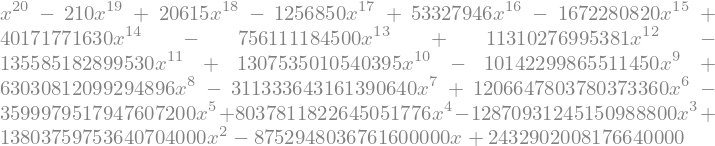

In [23]:
# Expanding the Wilkinson polynomial
We=sym.expand(W)
We 

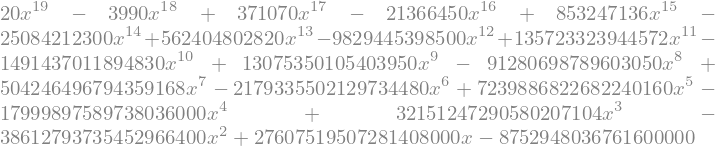

In [24]:
# Just computiong the derivative
Wep=sym.diff(We,x)
Wep

In [25]:
# Lamdifying the polynomial to be used with sympy
P=sym.lambdify(x,We)
Pp=sym.lambdify(x,Wep)

In [26]:
# Using scipy function to compute a root
# root = optimize.newton(P,16)
# print(root)

In [27]:
newton_method(P, Pp, 16.01, rel_error=1e-10, maxNumberIterations=10)

,$i$,$x_i$,$x_{i+1}$,$e_i$,$\frac{e_i}{e_{i-1}}$,$\frac{e_i}{e_{i-1}^\alpha}$,$\frac{e_i}{e_{i-1}^2}$
0,0,16.0100000000,16.0425006915,0.0325006915,0.0000000000,0.0000000000,0.0000000000
1,1,16.0425006915,16.0050204647,0.0374802268,1.1532132093,9.5854070309,35.4827283637
2,2,16.0050204647,16.0078597186,0.0028392538,0.0757533795,0.5765549711,2.0211558458
3,3,16.0078597186,15.9851271041,0.0227326145,8.0065452981,300.2282246866,2819.9469801818
4,4,15.9851271041,16.0029892675,0.0178621634,0.7857505074,8.1457523850,34.5648982597
5,5,16.0029892675,16.0136315293,0.0106422618,0.5957991522,7.1690902557,33.3553746866
6,6,16.0136315293,16.0001980846,0.0134334447,1.2622734683,20.9176811505,118.6095110764
7,7,16.0001980846,16.0178167527,0.0176186681,1.3115525115,18.8204280027,97.6333725295
8,8,16.0178167527,16.0287977529,0.0109810002,0.6232593802,7.5634001878,35.3749429376
9,9,16.0287977529,16.0248062796,0.0039914733,0.3634890493,5.9080101682,33.1016340099


Newtons Method did not converge. Too many iterations!!


<div id='acknowledgements' />

# Acknowledgements
[Back to TOC](#toc)

* _Material created by professor Claudio Torres_ (`claudio.torres@usm.cl`) _and assistants: Laura Bermeo, Alvaro Salinas, Axel Simonsen and Martín Villanueva. DI UTFSM. March 2016._ v1.1.
* _Update April 2020 - v1.32 - C.Torres_ : Re-ordering the notebook.
* _Update April 2021 - v1.33 - C.Torres_ : Updating format and re-re-ordering the notebook. Adding 'maxNumberIterations' to bisection, fpi and Newton's method. Adding more explanations.
* _Update April 2021 - v1.33 - C.Torres_ : Updating description and solution of 'Proposed classwork'.
* _Update September 2021 - v1.35 - C.Torres_ : Updating and commeting code more.
* _Update September 2021 - v1.36 - C.Torres_ : Updating the way we show the output tables.
* _Update September 2021 - v1.37 - C.Torres_ : Fixing typo suggested by Nicolás Tapia 2021-2. Thanks Nicolás! And removing extra code.
* _Update April 2023 - v1.38 - C.Torres_ : Fixing typo in section "Fixed Point Iteration and Cobweb diagram" suggested by Ricardo Olalquiaga 2023-1. Thanks Ricardo! Fixing another type in the Table of Content.
* _Update April 2023 - v1.39 - C.Torres_ : Fixing typo in section "Fixed Point Iteration and Cobweb diagram" and in "Newton's method" suggested by José Llanos Gaete 2023-1. Thanks José!
* _Update August 2023 - v1.40 - C.Torres_ : Updating bisection method to provide support for visualization without using Pandas.
* _Update March 2025 - v1.41 - C.Torres_ : Moved to new github repo, making the installation of library colorama automatically, updating code for coloring some equation in blue and red, and change the file name/title.
* _Update March 2025 - v1.42 - C.Torres_ : Adding Colab link.
* _Update August 2025 - v1.43 - C.Torres_ : Updating how to handle Colab's dependencies, updating some plots and updating `cobweb`.
* _Update August 2025 - v1.44 - C.Torres_ : Making small improvements in notation and adding Bolzano's theorem reference at the beginning of the bisection method.
* _Update August 2025 - v1.45 - C.Torres_ : Updating title format and adding support for LaTeX in CoLab.

<div id='extraexamples' />

# Extra examples
[Back to TOC](#toc)

## Propose Classwork
1. Build a FPI such that given $a$ computes $\displaystyle \frac{1}{a}$. The constraint is that you can't use a division in the 'final' FPI. Write down your solution below or go and see the [solution](#sol1). 

_Hint: I strongly suggest to use Newton's method._

In [28]:
print('Please try to solve it before you see the solution!!!')

Please try to solve it before you see the solution!!!


2. Build an algorithm that computes $\log(x_i)$ for $x_i=0.1*i+0.5$, for $i\in{0,1,2,\dots,10}$. The only special function available is $\exp(x)$, in particular use _np.exp(x)_. You can also use $*$, $÷$, $+$, and $-$. It would be nice to use the result from previous example to replace $÷$.

# In class

Which function shows quadratic convergence? Why?

,$i$,$x_i$,$x_{i+1}$,$e_i$,$\frac{e_i}{e_{i-1}}$,$\frac{e_i}{e_{i-1}^\alpha}$,$\frac{e_i}{e_{i-1}^2}$
0,0,3.0000000000,2.7333333333,0.2666666667,NaN,NaN,NaN
1,1,2.7333333333,2.5525203252,0.1808130081,0.6780487805,1.5347292605,2.5426829268
2,2,2.5525203252,2.4337859123,0.1187344129,0.6566696394,1.8897495317,3.6317610455
3,3,2.4337859123,2.3579112134,0.0758746990,0.6390287123,2.3848632518,5.3820008621
4,4,2.3579112134,2.3104331500,0.0474780634,0.6257430215,3.0798824764,8.2470577167
5,5,2.3104331500,2.2811657946,0.0292673554,0.6164395368,4.0538044799,12.9836706220
6,6,2.2811657946,2.2633049812,0.0178608134,0.6102639994,5.4118392129,20.8513543865
7,7,2.2633049812,2.2524757347,0.0108292465,0.6063131795,7.2959435122,33.9465604055
8,8,2.2524757347,2.2459365357,0.0065391990,0.6038461667,9.8994576576,55.7606814775
9,9,2.2459365357,2.2419977848,0.0039387509,0.6023292551,13.4869587817,92.1105557855


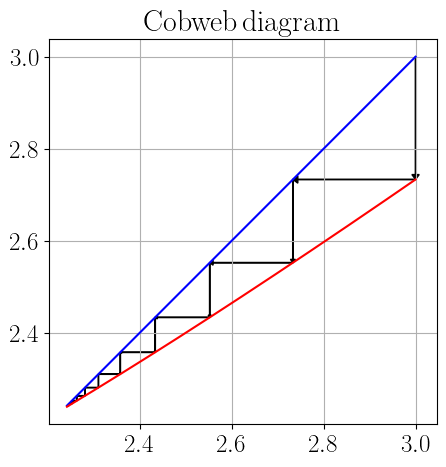

In [29]:
g1 = lambda x: (4./5.)*x+1./x
g2 = lambda x: x/2.+5./(2*x)
g3 = lambda x: (x+5.)/(x+1)
fpi(g1, 3.0, 10, True)

### Building a FPI to compute the cubic root of 7

In [30]:
# What is 'a'? Can we find another 'a'?
a = -3*(1.7**2)
print(a)

-8.669999999999998


,$i$,$x_i$,$x_{i+1}$,$e_i$,$\frac{e_i}{e_{i-1}}$,$\frac{e_i}{e_{i-1}^\alpha}$,$\frac{e_i}{e_{i-1}^2}$
0,0,1.7000000000,1.9407151096,0.2407151096,NaN,NaN,NaN
1,1,1.9407151096,1.9050217836,0.0356933259,0.1482803717,0.3575490403,0.6159994359
2,2,1.9050217836,1.9149952799,0.0099734962,0.2794218792,2.1918499906,7.8284069055
3,3,1.9149952799,1.9123789078,0.0026163720,0.2623324846,4.5251437459,26.3029612960
4,4,1.9123789078,1.9130779941,0.0006990863,0.2671968386,10.5385483890,102.1249403998
5,5,1.9130779941,1.9128920879,0.0001859062,0.2659273937,23.7110225862,380.3927776292
6,6,1.9128920879,1.9129415886,0.0000495007,0.2662670485,53.8295316374,1432.2655048556
7,7,1.9129415886,1.9129284127,0.0000131759,0.2661767579,121.9120607305,5377.2324999715
8,8,1.9129284127,1.9129319201,0.0000035074,0.2662008017,276.2805406546,20203.5604717720
9,9,1.9129319201,1.9129309865,0.0000009337,0.2661944019,626.0081808815,75894.1168915227


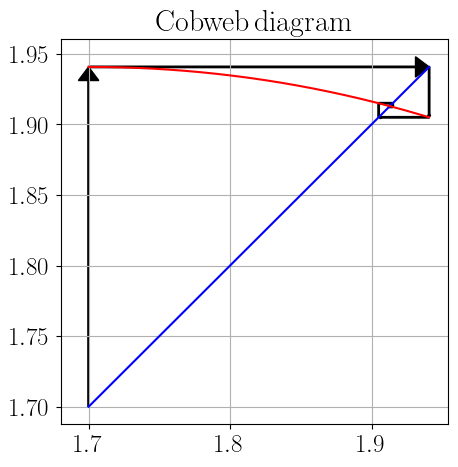

-1.0819690920982339e-08


In [31]:
f = lambda x: x**3-7
g =  lambda x: f(x)/a+x
r=fpi(g, 1.7, 14, True)
print(f(r))

### Playing with some roots

The following example proposed a particular function $f(x)$. 
The idea here is first obtain an initial guess for applying the Newton's method from the plot in semilogy scale.
The plot of $f(x)$ (blue) shows that there seems to be 2 roots in the interval plotted.
Now, the plot of $f'(x)$ (magenta) indicates that the derivative may also have a 0 together with a root, this means that the multiplicity of that root may be higher than 1. **Do you see it?**

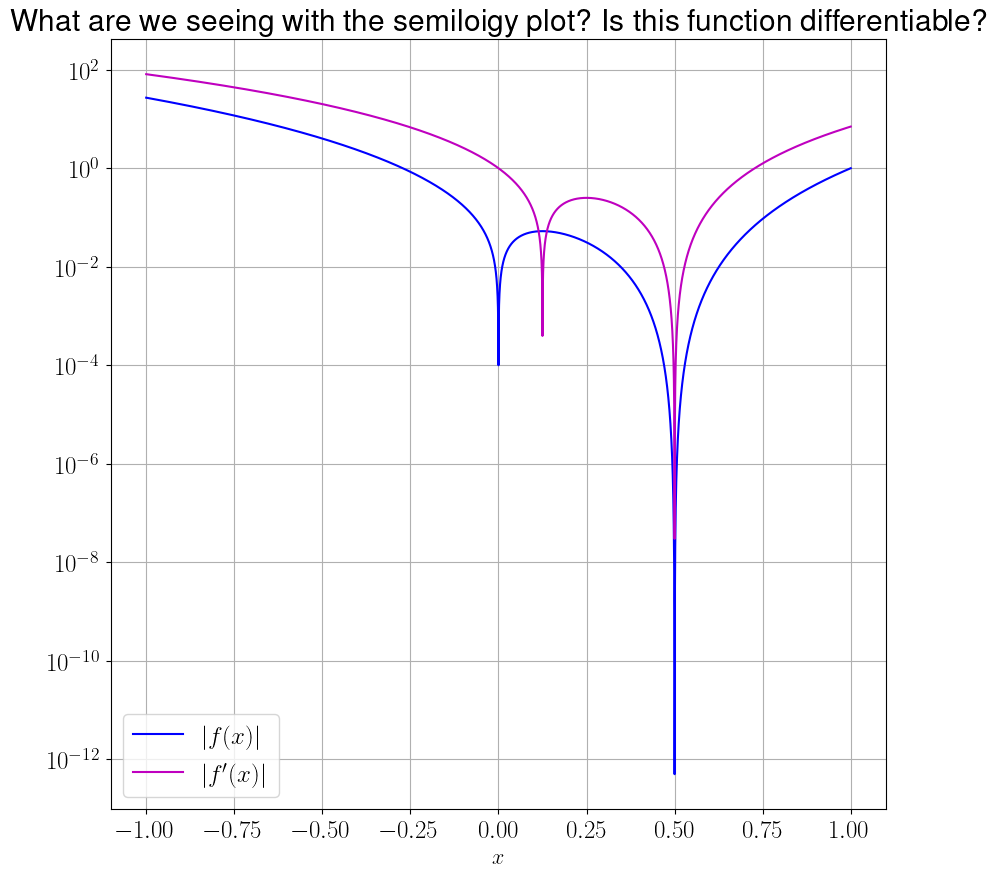

In [32]:
f = lambda x: 8*x**4-12*x**3+6*x**2-x
fp = lambda x: 32*x**3-36*x**2+12*x-1

x = np.linspace(-1,1,10000)
plt.figure(figsize=(10,10))

plt.title('What are we seeing with the semiloigy plot? Is this function differentiable?')
plt.semilogy(x,np.abs(f(x)),'b-',label=r'$|f(x)|$')
plt.semilogy(x,np.abs(fp(x)),'m-',label=r"$|f'(x)|$")
plt.grid()
plt.legend()
plt.xlabel(r'$x$',fontsize=16)
plt.show()

In [33]:
r=newton_method(f, fp, 0.4, rel_error=1e-8, m=1)
print([r,f(r)])
# Is this showing quadratic convergence? If not, can you fix it?

,$i$,$x_i$,$x_{i+1}$,$e_i$,$\frac{e_i}{e_{i-1}}$,$\frac{e_i}{e_{i-1}^\alpha}$,$\frac{e_i}{e_{i-1}^2}$
0,0,0.4000000000,0.4363636364,0.0363636364,0.0000000000,0.0000000000,0.0000000000
1,1,0.4363636364,0.4586595886,0.0222959522,0.6131386861,4.7546137810,16.8613138686
2,2,0.4586595886,0.4728665654,0.0142069768,0.6371998210,6.6854108733,28.5791705436
3,3,0.4728665654,0.4820874099,0.0092208445,0.6490363622,8.9967528627,45.6843403691
4,4,0.4820874099,0.4881331524,0.0060457425,0.6556603932,11.8718891457,71.1063278311
5,5,0.4881331524,0.4921210847,0.0039879323,0.6596265522,15.5037819584,109.1059613639
6,6,0.4921210847,0.4947614808,0.0026403961,0.6620965214,20.1252241907,166.0250150478
7,7,0.4947614808,0.4965138385,0.0017523577,0.6636722755,26.0285404605,251.3533000745
8,8,0.4965138385,0.4976786184,0.0011647799,0.6646930088,33.5858180781,379.3135449254
9,9,0.4976786184,0.4984536173,0.0007749988,0.6653607474,43.2731170072,571.2330225492


[0.49999718771149326, 0.0]


<div id='sol1' />

## Solutions
Problem: Build a FPI such that given $a$ computes $\displaystyle \frac{1}{a}$

Solution: Apply Newton's method to the following function: $f(x)=a-\frac{1}{x}$. Make sure you simplify the final expression.

In [34]:
# We are finding the 1/a
# Solution code:
a = 2.1
g = lambda x: 2*x-a*x**2
gp = lambda x: 2-2*a*x
r=fpi(g, 0.7, 7, flag_cobweb=False)
print('Reciprocal found :',r)
print('Reciprocal computed explicitly: ', 1/a)
# Are we seeing quadratic convergence?

,$i$,$x_i$,$x_{i+1}$,$e_i$,$\frac{e_i}{e_{i-1}}$,$\frac{e_i}{e_{i-1}^\alpha}$,$\frac{e_i}{e_{i-1}^2}$
0,0,0.7000000000,0.3710000000,0.3290000000,NaN,NaN,NaN
1,1,0.3710000000,0.4529539000,0.0819539000,0.2491000000,0.4951799738,0.7571428571
2,2,0.4529539000,0.4750566054,0.0221027054,0.2696968100,1.2656881308,3.2908355795
3,3,0.4750566054,0.4761877763,0.0011311709,0.0511779387,0.5398483531,2.3154603813
4,4,0.4761877763,0.4761904762,0.0000026999,0.0023867984,0.1580649031,2.1100246103
5,5,0.4761904762,0.4761904762,0.0000000000,0.0000056698,0.0156742306,2.1000206476
6,6,0.4761904762,0.4761904762,0.0000000000,0.0000000000,0.0000000000,0.0000000000


Reciprocal found : 0.47619047619047616
Reciprocal computed explicitly:  0.47619047619047616


### What is this plot telling us?

This plots shows that, even if we don't know the exact value of $g'(r)$, we can determine if the FPI will convergan by looking at the plot.
In this plot we observe that when plotting $g'(x)$ (magenta), we can determine that the value of $|g'(r)|$ will be less than 1 since it is between the black lines, that are located at $y=-1$ and $y=1$.

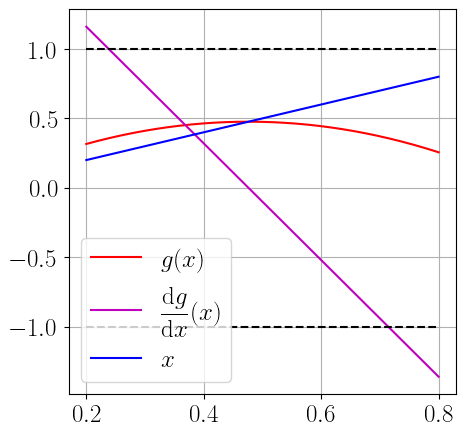

In [35]:
xx=np.linspace(0.2,0.8,1000)
plt.figure(figsize=(5,5))
plt.plot(xx,g(xx),'r-',label=r'$g(x)$')
plt.plot(xx,gp(xx),'m-',label=r'$\displaystyle\frac{\mathrm{d} g}{\mathrm{d}x}(x)$')
plt.plot(xx,xx,'b-',label=r'$x$')
plt.plot(xx,0*xx+1,'k--')
plt.plot(xx,0*xx-1,'k--')
plt.legend(loc='lower left')
plt.grid()
plt.show()